---
title: Lieb not so quantum contact
date: 2022-04-18
date-format: short
---

In [182]:
import kwant
import matplotlib
import matplotlib.pyplot as plt

import scipy as scp
import numpy as np
from kwant.physics import dispersion
from scipy import sparse as sp


def make_system(
    a=1, t_1=1.0, t_2=1.0, L=3, W=3, ratio=0.25, V=5, potent=True, lead=True
):
    lat = kwant.lattice.Polyatomic(
        [[2 * a, 0], [0, 2 * a]], [[0, 0], [0, a], [a, 0]], norbs=1
    )
    lat.a, lat.b, lat.c = lat.sublattices

    syst = kwant.Builder()

    L2 = L * 2
    W2 = W * 2

    sigx = L2 / 5
    sigy = W2 * ratio

    # Onsites
    if potent == True:

        def potential(site):
            (x, y) = site.pos
            n = 50
            return (V * np.exp(-((((x - L2 / 2)) / sigx) ** 2))) * (
                1 - np.exp(-((((y - W2 / 2) / sigy)) ** 2))
            )

    else:

        def potential(site):
            return 0

    syst[(lat.a(n, m) for n in range(L) for m in range(W + 1))] = potential
    syst[(lat.b(n, m) for n in range(L) for m in range(W))] = potential
    syst[(lat.c(n, m) for n in range(L) for m in range(W + 1))] = potential

    # Hopping t1
    syst[((lat.a(n, m), lat.b(n, m)) for n in range(L) for m in range(W))] = t_1
    syst[((lat.a(n, m), lat.c(n, m)) for n in range(L) for m in range(W + 1))] = t_1
    syst[((lat.b(n, m), lat.c(n, m)) for n in range(L) for m in range(W))] = t_2
    syst[((lat.b(n + 1, m), lat.c(n, m)) for n in range(L - 1) for m in range(W))] = t_2
    syst[
        ((lat.b(n, m - 1), lat.c(n, m)) for n in range(L) for m in range(1, W + 1))
    ] = t_2
    syst[
        ((lat.b(n - 1, m + 1), lat.c(n, m)) for n in range(1, L) for m in range(W - 1))
    ] = t_2  #
    syst[
        ((lat.b(n, m), lat.a(n, m + 1)) for n in range(L) for m in range(W - 1 + 1))
    ] = t_1
    syst[
        ((lat.c(n, m), lat.a(n + 1, m)) for n in range(L - 1) for m in range(W + 1))
    ] = t_1
    syst[((lat.c(n, W), lat.b(n + 1, W - 1)) for n in range(L - 1))] = t_2

    if not lead:
        return syst, lat

    # Left lead
    sym_left_lead = kwant.TranslationalSymmetry([-2 * a, 0])
    left_lead = kwant.Builder(sym_left_lead)
    # Onsites
    left_lead[(lat.a(n, m) for n in range(L) for m in range(W + 1))] = 0
    left_lead[(lat.b(n, m) for n in range(L) for m in range(W))] = 0
    left_lead[(lat.c(n, m) for n in range(L) for m in range(W + 1))] = 0
    # Hopping t1
    left_lead[((lat.a(n, m), lat.b(n, m)) for n in range(L) for m in range(W))] = t_1
    left_lead[
        ((lat.a(n, m), lat.c(n, m)) for n in range(L) for m in range(W + 1))
    ] = t_1
    left_lead[((lat.b(n, m), lat.c(n, m)) for n in range(L) for m in range(W))] = t_2
    left_lead[
        ((lat.b(n + 1, m), lat.c(n, m)) for n in range(L - 1) for m in range(W))
    ] = t_2
    left_lead[
        ((lat.b(n, m - 1), lat.c(n, m)) for n in range(L) for m in range(1, W + 1))
    ] = t_2
    left_lead[
        ((lat.b(n - 1, m + 1), lat.c(n, m)) for n in range(1, L) for m in range(W - 1))
    ] = t_2
    left_lead[
        ((lat.b(n, m), lat.a(n, m + 1)) for n in range(L) for m in range(W - 1 + 1))
    ] = t_1
    left_lead[
        ((lat.c(n, m), lat.a(n + 1, m)) for n in range(L - 1) for m in range(W + 1))
    ] = t_1

    left_lead[((lat.c(n, W), lat.b(n + 1, W - 1)) for n in range(L - 1))] = t_2

    syst.attach_lead(left_lead)
    left_lead_fin = left_lead.finalized()
    syst.attach_lead(left_lead.reversed())
    syst_fin = syst.finalized()
    return syst_fin, left_lead_fin, lat


def plot_bandstructure(flead, momenta, label=None, title=None):
    bands = kwant.physics.Bands(flead)
    energies = [bands(k) for k in momenta]

    plt.figure()
    plt.title(title)
    plt.plot(momenta, energies, label=label)
    plt.xlabel("momentum [(lattice constant)^-1]")
    plt.ylabel("energy [t]")
    plt.show()


def plot_conductance(syst, energies):
    data = []
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy)
        data.append(smatrix.transmission(1, 0))

    plt.figure()
    plt.plot(energies, data)
    plt.xlabel("energy [t]")
    plt.ylabel("conductance [e^2/h]")
    plt.show()


def plot_density(sys, ener, it=-1, title="empty"):

    wf = kwant.wave_function(sys, energy=ener)

    t = np.shape(wf(0))
    nwf = wf(0)[0] * 0

    for i in range(t[0] // 2 + 1):
        test = wf(0)[i]
        nwf += test

    psi = abs(nwf) ** 2

    if it == -1:
        title = "density"
    elif it > -1:
        title = "density"

    title2 = title + ".pdf"

    kwant.plotter.map(sys, psi, method="linear", vmin=0)

    J_0 = kwant.operator.Current(sys)
    c = J_0(nwf)

    kwant.plotter.current(sys, c)

    plt.close()

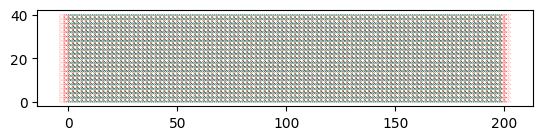

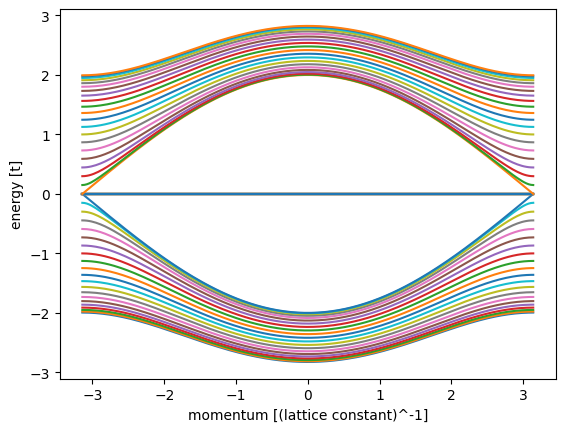

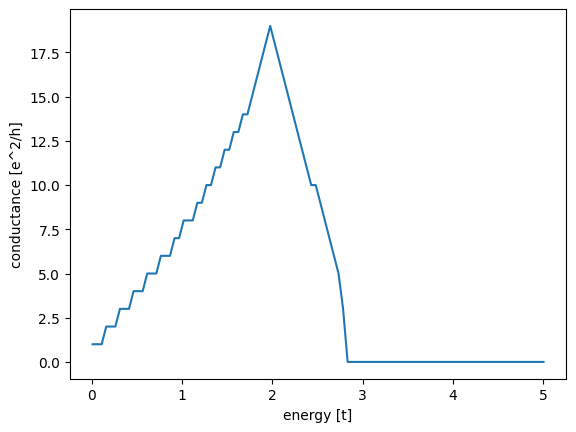

In [192]:
fsyst,lead,lat= make_system(t_2=0, t_1=1,L=100,W=20,V=2,ratio=0.2,lead=True,potent=False)
kwant.plot(fsyst)
plt.show()

plot_bandstructure(lead,momenta=np.linspace(-np.pi,np.pi,200))
plot_conductance(fsyst, np.linspace(0.01,5,100))

#plot_density(fsyst,1, it=-1,title="empty")